In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = r"C:\Users\prasi\Downloads\Flood satellite imagery\Water Bodies Dataset"
IMG_DIR  = os.path.join(DATA_DIR, "Images")
MSK_DIR  = os.path.join(DATA_DIR, "Masks")

# collect all file‑pairs
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
all_masks  = sorted(glob.glob(os.path.join(MSK_DIR, "*.jpg")))
print(f"Found {len(all_images)} images and {len(all_masks)} masks.")

Found 2841 images and 2841 masks.


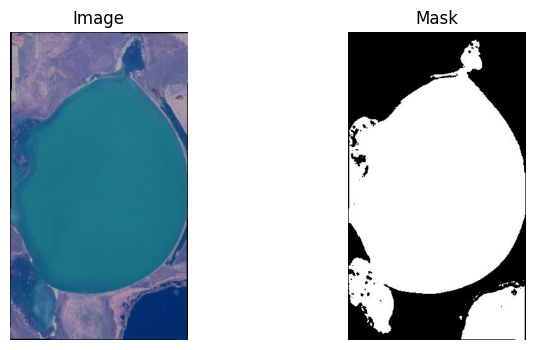

In [3]:
def show_sample(idx):
    img = plt.imread(all_images[idx])
    m   = plt.imread(all_masks[idx])
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Mask");  plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.savefig("sample_img.jpg", dpi=300)
    
show_sample(10)

In [4]:
# Split your data (80-10-10 split as an example)
split_1 = int(0.8 * len(all_images))
split_2 = int(0.9 * len(all_images))

train_images = all_images[:split_1]
train_masks  = all_masks[:split_1]

val_images = all_images[split_1:split_2]
val_masks  = all_masks[split_1:split_2]

test_images = all_images[split_2:]
test_masks  = all_masks[split_2:]

# Set image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 16

# Preprocessing function
def preprocess(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_jpeg(msk, channels=1)

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE], method="nearest")

    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk, tf.float32) / 255.0        # normalize 0–255 to 0–1
    msk = tf.cast(tf.round(msk), tf.int32) 

    '''msk = tf.cast(msk, tf.uint8)  # or tf.int32
'''
    '''msk = tf.cast(msk, tf.float32) / 255.0
    msk = tf.round(msk)  # binary mask'''

    return img, msk

# Dataset preparation function
def prepare(images, masks, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = (ds
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(batch)
          .prefetch(tf.data.AUTOTUNE))
    return ds

# Prepare datasets
train_ds = prepare(train_images, train_masks)
val_ds   = prepare(val_images, val_masks)
test_ds  = prepare(test_images, test_masks)


In [5]:
def inception_block(x, filters):
    """
    A simple Inception block that splits into 4 paths:
      1) 1×1 conv
      2) 1×1 conv → 3×3 conv
      3) 1×1 conv → 5×5 conv
      4) 3×3 max‑pool → 1×1 conv
    """
    # Path 1: 1x1
    path1 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    
    # Path 2: 1x1 → 3x3
    path2 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(path2)
    
    # Path 3: 1x1 → 5x5
    path3 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters, (5,5), padding='same', activation='relu')(path3)
    
    # Path 4: 3x3 pool → 1x1
    path4 = layers.MaxPool2D((3,3), strides=1, padding='same')(x)
    path4 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(path4)
    
    # Concatenate
    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def unet_with_inception(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)
    # Encoder
    c1 = inception_block(inputs, 16)         # replaces two plain convs
    p1 = layers.MaxPool2D()(c1)

    c2 = inception_block(p1, 32)
    p2 = layers.MaxPool2D()(c2)

    c3 = inception_block(p2, 64)
    p3 = layers.MaxPool2D()(c3)

    # Bottleneck as a bigger inception
    b = inception_block(p3, 128)
    b = inception_block(b, 128)

    # Decoder
    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u3 = layers.concatenate([u3, c3])
    c4 = inception_block(u3, 64)

    u4 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u4 = layers.concatenate([u4, c2])
    c5 = inception_block(u4, 32)

    u5 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u5 = layers.concatenate([u5, c1])
    c6 = inception_block(u5, 16)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)
    return Model(inputs, outputs)

model = unet_with_inception()

#Dice Coefficient Metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


loss_fn = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=[
        'accuracy',
        dice_coef  
    ]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      6,416 │ conv2d_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         64 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 64)               │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     25,632 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                 

 Total params: 2,196,657 (8.38 MB)

 Trainable params: 2,196,657 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

125 m58.3 s

In [6]:
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Check what metrics are available
print("Available metrics:", history.history.keys())

# Extract metrics
final_train_loss = history.history['loss'][-1]
final_val_loss   = history.history['val_loss'][-1]

final_train_acc  = history.history['accuracy'][-1]
final_val_acc    = history.history['val_accuracy'][-1]

# Dice metric history key matches the function name
final_train_dice = history.history['dice_coef'][-1]
final_val_dice   = history.history['val_dice_coef'][-1]

print(f"\nFinal Results after {EPOCHS} Epochs")
print(f"Train Loss:     {final_train_loss:.4f}")
print(f"Val Loss:       {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_acc:.4f}")
print(f"Val Accuracy:   {final_val_acc:.4f}")
print(f"Train Dice:     {final_train_dice:.4f}")
print(f"Val Dice:       {final_val_dice:.4f}")


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6881 - dice_coef: 0.3454 - loss: 0.1473 - val_accuracy: 0.7603 - val_dice_coef: 0.5288 - val_loss: 0.1306
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7696 - dice_coef: 0.6050 - loss: 0.1274 - val_accuracy: 0.7685 - val_dice_coef: 0.5013 - val_loss: 0.1279
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7761 - dice_coef: 0.6180 - loss: 0.1233 - val_accuracy: 0.7047 - val_dice_coef: 0.6381 - val_loss: 0.1386
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7847 - dice_coef: 0.6427 - loss: 0.1208 - val_accuracy: 0.7958 - val_dice_coef: 0.5758 - val_loss: 0.1208
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7926 - dice_coef: 0.6426 - loss: 0.1175 - val_accuracy: 0.7976 - val_dice_coef: 0.5763 - val_loss: 0.1181
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8006 - dice_coef: 0.6629 - loss: 0.1136 - val_accuracy: 0.8106 - val

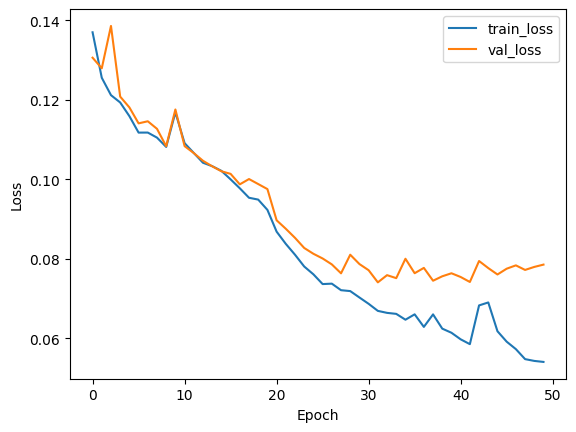

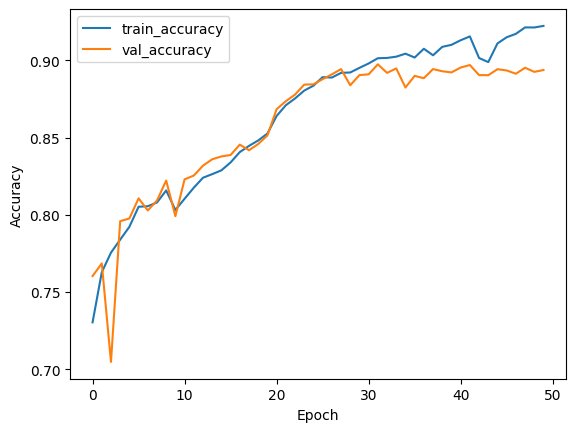

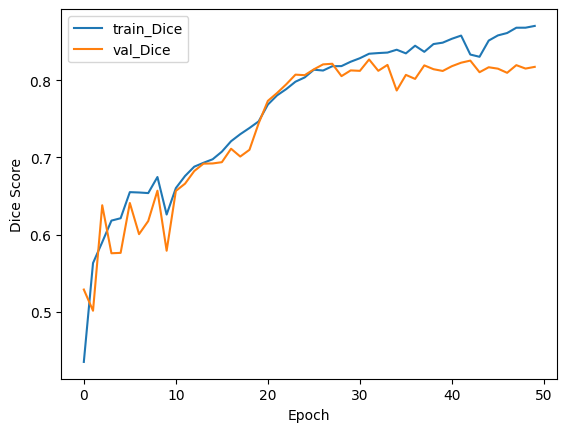

In [7]:
# 1) Loss curve
plt.figure() 
plt.plot(history.history["loss"],     label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve_inception_unet.png", dpi=300)
plt.show()

# 2) Accuracy curve
plt.figure()
plt.plot(history.history["accuracy"],      label="train_accuracy")
plt.plot(history.history["val_accuracy"],  label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve_inception_unet.png", dpi=300)
plt.show()

# 3) Dice Score curve
plt.figure()
plt.plot(history.history["dice_coef"],     label="train_Dice")
plt.plot(history.history["val_dice_coef"], label="val_Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.savefig("dice_curve_inception_unet.png", dpi=300)
plt.show()


In [8]:
# If you compiled with metrics=['accuracy', dice_coef], then evaluate returns:
#    [loss, accuracy, dice_coef]
loss, accuracy, dice = model.evaluate(test_ds)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Dice:     {dice:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9151 - dice_coef: 0.8575 - loss: 0.0630
Test Loss:     0.0660
Test Accuracy: 0.9106
Test Dice:     0.8526


15.2 s

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


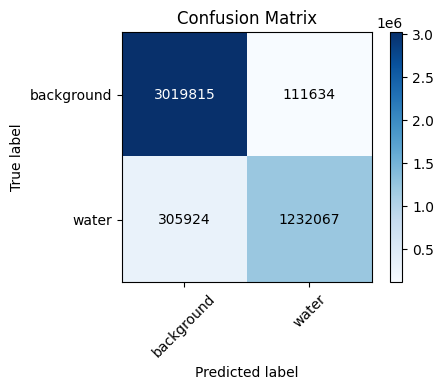

<Figure size 640x480 with 0 Axes>

In [9]:
# Build y_true, y_pred lists as before…
# (no changes here)

y_true, y_pred = [], []
for imgs, masks in test_ds:
    preds = (model.predict(imgs) > 0.5).astype(int)
    y_pred.append(preds.ravel())
    y_true.append(masks.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


cm = confusion_matrix(y_true, y_pred)
classes = ["background", "water"]

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i,j], ha="center", va="center",
             color="white" if cm[i,j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_inception_unet.jpg", dpi=300)


Test ROC AUC: 0.9502


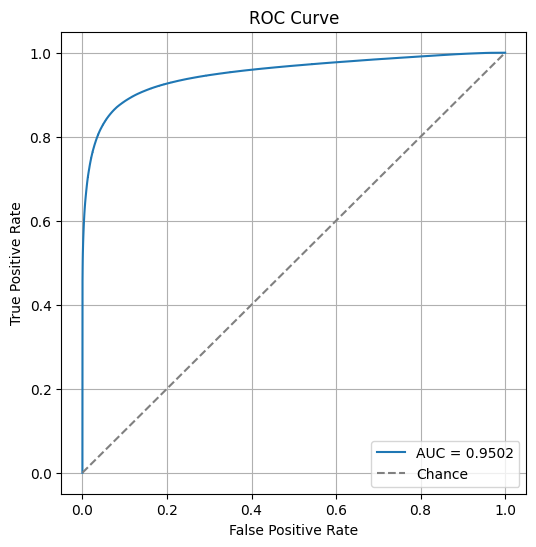

<Figure size 640x480 with 0 Axes>

In [10]:


# 1) Gather probabilities & labels
y_true, y_prob = [], []
for imgs, masks in test_ds:
    probs = model.predict(imgs, verbose=0)[...,0]  # (batch, H, W)
    y_prob.append(probs.ravel())
    y_true.append(masks.numpy().ravel())

y_prob = np.concatenate(y_prob)
y_true = np.concatenate(y_true)

# 2) Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
print(f"Test ROC AUC: {auc:.4f}")

# 3) Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.savefig("auc_inception_unet.jpg", dpi=300)


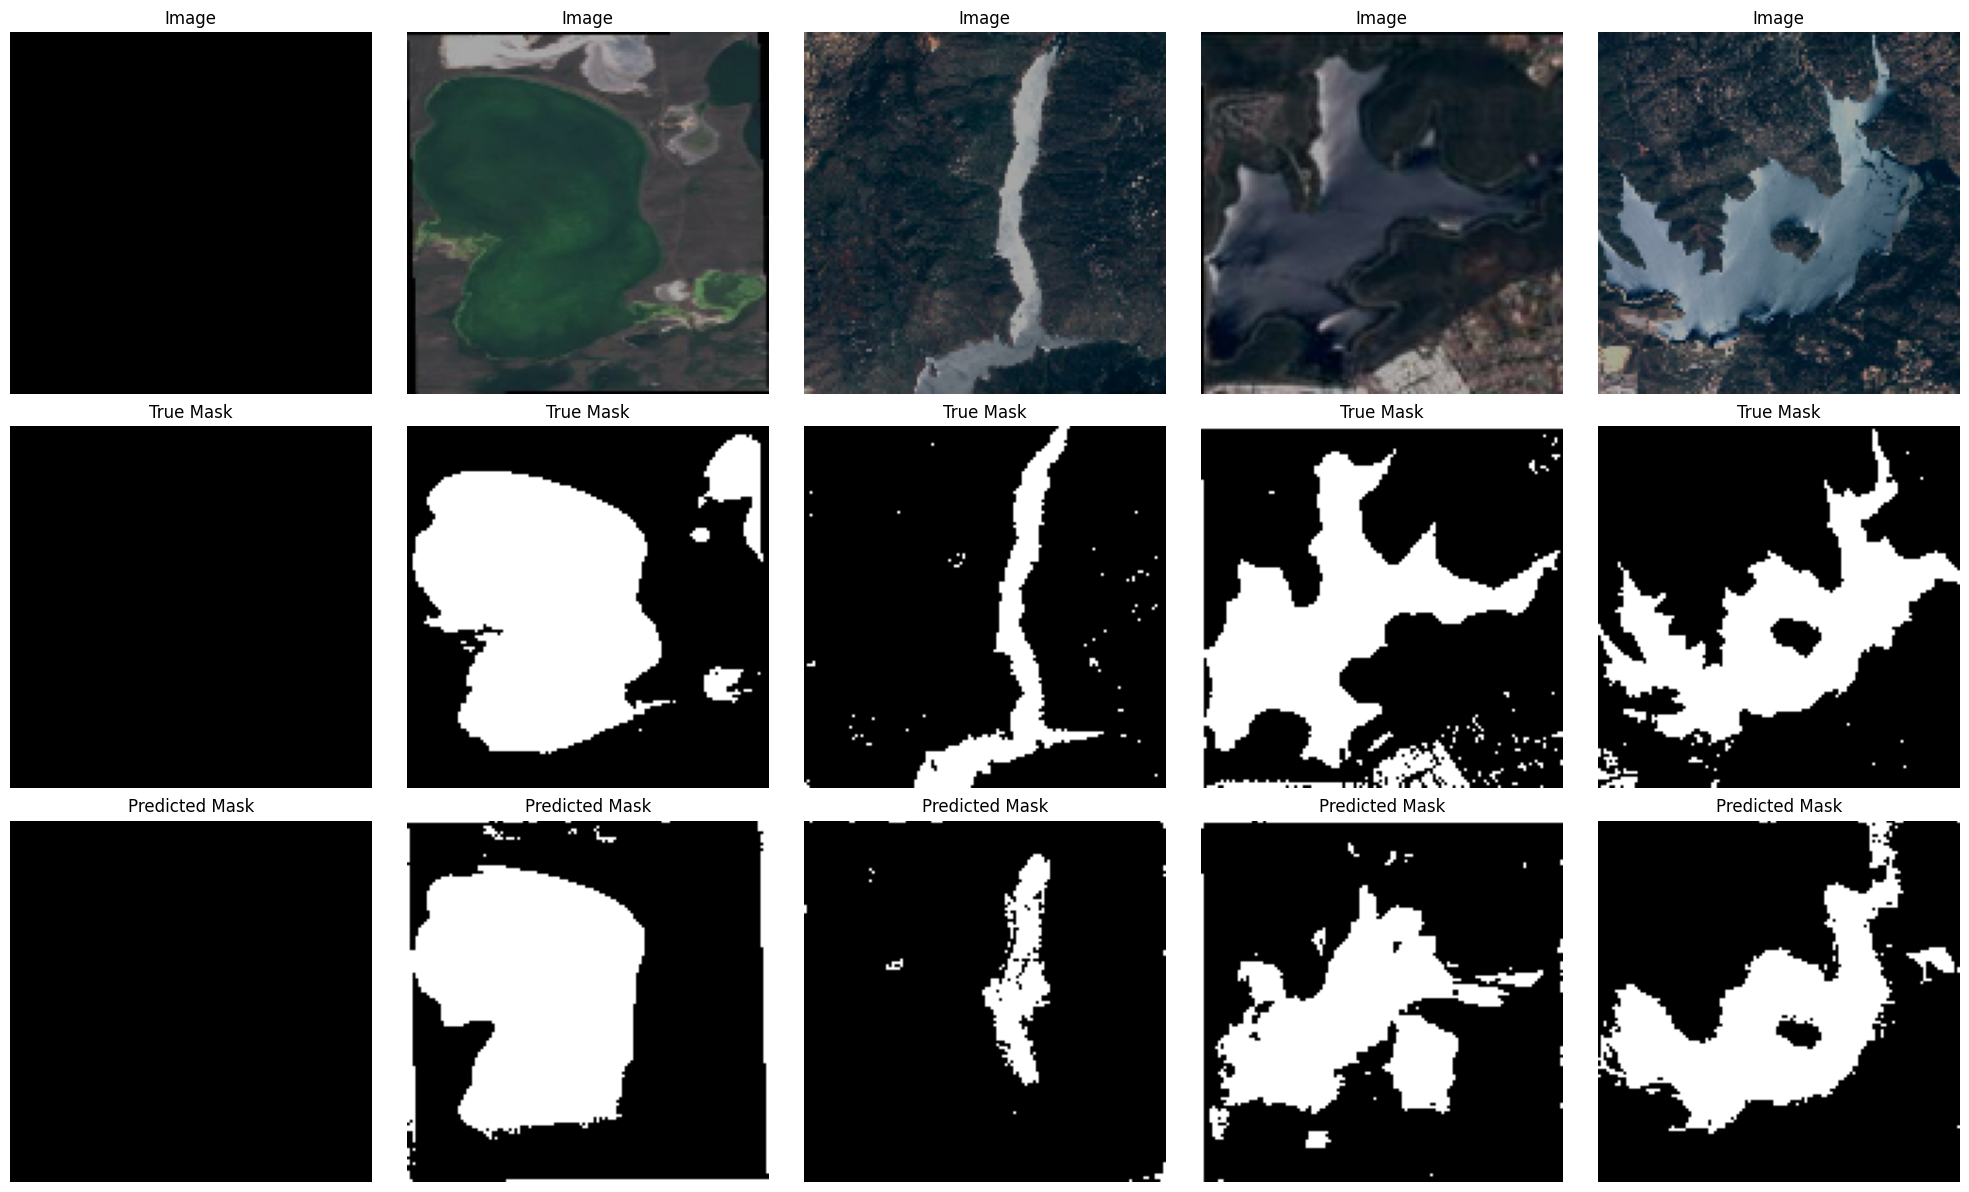

<Figure size 640x480 with 0 Axes>

In [11]:
def visualize_test_predictions(dataset, model, num_examples=5):
    """
    Displays `num_examples` samples from `dataset` with:
      - Left:  input image
      - Center: ground-truth mask
      - Right: predicted mask (thresholded 0.5)
    """
    # Unbatch so we can take individual samples
    ds = dataset.unbatch().batch(1)
    
    plt.figure(figsize=(num_examples * 4, 3 * 4))
    
    for i, (img_batch, mask_batch) in enumerate(ds.take(num_examples)):
        # img_batch: (1, H, W, 3), mask_batch: (1, H, W, 1)
        img  = img_batch[0].numpy()
        true = mask_batch[0,...,0].numpy()
        
        # Predict on this single image
        pred_prob = model.predict(img_batch, verbose=0)[0,...,0]
        pred = (pred_prob > 0.5).astype(np.uint8)
        
        # Plot input image
        ax = plt.subplot(3, num_examples, i+1)
        ax.imshow(img)
        ax.set_title("Image")
        ax.axis("off")
        
        # Plot true mask
        ax = plt.subplot(3, num_examples, num_examples + i+1)
        ax.imshow(true, cmap="gray")
        ax.set_title("True Mask")
        ax.axis("off")
        
        # Plot predicted mask
        ax = plt.subplot(3, num_examples, 2*num_examples + i+1)
        ax.imshow(pred, cmap="gray")
        ax.set_title("Predicted Mask")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    plt.savefig("output_inception_unet.jpg", dpi=300)

# Usage: show 5 examples from your test set
visualize_test_predictions(test_ds, model, num_examples=5)
